In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import umap
import torch
import torch.nn as nn
import torch.nn.functional as F
import gc
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
os.chdir('../IConNet/')
print(os.getcwd())

/home/linh/projects/IConNet


In [3]:
from IConNet.acov.audio_vqvae import VqVaeClsLoss
from IConNet.trainer.train_torch import Trainer, get_dataloader
from IConNet.acov.model import SCB8 as SCB
from omegaconf import OmegaConf as ocf

import pandas as pd
import IPython.display as ipd
import seaborn as sns

from IConNet.acov.visualize import (
    visualize_speech_codebook, visualize_embedding_umap,
    get_embedding_color_v2
)

In [4]:
dataset_name = 'ravdess'
experiment_prefix = "scb8"
log_dir = f'../{experiment_prefix}_models/{dataset_name}/predictions2'
data_dir = "../data/data_preprocessed/"

dataset_config_path = f'config/dataset/{dataset_name}.yaml'
dataset_config = ocf.load(dataset_config_path)
print(dataset_config)

sr = 16000
batch_size = 4
in_channels = 1
num_segments = 8
out_channels = num_segments*batch_size
embedding_dim = 1023
num_embeddings = 384
cls_dim = 512
downsampling = 8
commitment_cost = 0.1
learning_rate = 1e-3
num_tokens_per_second = 16
max_num_tokens = 256
num_classes = 4
num_training_updates = 1000
log_interval = 100
test_interval = 100

{'name': 'ravdess', 'dataset_class': 'WaveformDataset', 'root': 'ravdess/', 'audio_dir': 'full_release/', 'feature_dir': 'preprocessing/', 'label_name': 'label_emotion_key', 'feature_name': 'audio16k', 'num_classes': 8, 'label_values': ['neu', 'cal', 'hap', 'sad', 'ang', 'fea', 'dis', 'sur'], 'classnames': ['neu', 'cal', 'hap', 'sad', 'ang', 'fea', 'dis', 'sur'], 'target_labels': ['ang', 'neu', 'sad', 'hap']}


In [7]:
import glob
dt = []
log_dir = f'../{experiment_prefix}_models/{dataset_name}/predictions2/'
for i, f in enumerate(glob.glob(f"{log_dir}val_result*")):
    d = {'filename': f}
    r = torch.load(f)
    keys = list(r.keys())[:6]
    for k in keys:
        d[k] = r[k]
    dt.append(d)
df = pd.DataFrame(dt)
df

filename  epoch  step  \
0   ../scb8_models/ravdess/predictions2/val_result...     35  3451   
1   ../scb8_models/ravdess/predictions2/val_result...     26  2551   
2   ../scb8_models/ravdess/predictions2/val_result...     38  3751   
3   ../scb8_models/ravdess/predictions2/val_result...     15  1451   
4   ../scb8_models/ravdess/predictions2/val_result...      4   351   
5   ../scb8_models/ravdess/predictions2/val_result...     18  1751   
6   ../scb8_models/ravdess/predictions2/val_result...      7   651   
7   ../scb8_models/ravdess/predictions2/val_result...     48  4659   
8   ../scb8_models/ravdess/predictions2/val_result...     19  1851   
9   ../scb8_models/ravdess/predictions2/val_result...      9   851   
10  ../scb8_models/ravdess/predictions2/val_result...     49  4759   
11  ../scb8_models/ravdess/predictions2/val_result...     17  1651   
12  ../scb8_models/ravdess/predictions2/val_result...     27  2651   
13  ../scb8_models/ravdess/predictions2/val_result...     31  3051   
14  ../scb8_models/ravdess/predictions2/val_result...     45  4359   
15  ../scb8_models/ravdess/predictions2/val_result...      8   751   
16  ../scb8_models/ravdess/predictions2/val_result...     28  2751   
17  ../scb8_models/ravdess/predictions2/val_result...      1    51   
18  ../scb8_models/ravdess/predictions2/val_result...     47  4559   
19  ../scb8_models/ravdess/predictions2/val_result...     32  3151   
20  ../scb8_models/ravdess/predictions2/val_result...     30  2951   
21  ../scb8_models/ravdess/predictions2/val_result...     21  1996   
22  ../scb8_models/ravdess/predictions2/val_result...     39  3851   
23  ../scb8_models/ravdess/predictions2/val_result...     22  2151   
24  ../scb8_models/ravdess/predictions2/val_result...     13  1251   
25  ../scb8_models/ravdess/predictions2/val_result...     21  2051   
26  ../scb8_models/ravdess/predictions2/val_result...     40  3951   
27  ../scb8_models/ravdess/predictions2/val_result...     46  4459   
28  ../scb8_models/ravdess/predictions2/val_result...     12  1151   
29  ../scb8_models/ravdess/predictions2/val_result...     51  4959   
30  ../scb8_models/ravdess/predictions2/val_result...     16  1551   
31  ../scb8_models/ravdess/predictions2/val_result...     10   951   
32  ../scb8_models/ravdess/predictions2/val_result...     50  4859   
33  ../scb8_models/ravdess/predictions2/val_result...     24  2351   
34  ../scb8_models/ravdess/predictions2/val_result...     34  3351   
35  ../scb8_models/ravdess/predictions2/val_result...     25  2451   
36  ../scb8_models/ravdess/predictions2/val_result...      6   551   
37  ../scb8_models/ravdess/predictions2/val_result...      5   451   
38  ../scb8_models/ravdess/predictions2/val_result...     33  3251   
39  ../scb8_models/ravdess/predictions2/val_result...     37  3651   
40  ../scb8_models/ravdess/predictions2/val_result...      3   251   
41  ../scb8_models/ravdess/predictions2/val_result...     11  1051   
42  ../scb8_models/ravdess/predictions2/val_result...     20  1951   
43  ../scb8_models/ravdess/predictions2/val_result...      2   151   
44  ../scb8_models/ravdess/predictions2/val_result...     36  3551   
45  ../scb8_models/ravdess/predictions2/val_result...     44  4259   
46  ../scb8_models/ravdess/predictions2/val_result...     43  4159   
47  ../scb8_models/ravdess/predictions2/val_result...     14  1351   
48  ../scb8_models/ravdess/predictions2/val_result...     29  2851   
49  ../scb8_models/ravdess/predictions2/val_result...     23  2251   
50  ../scb8_models/ravdess/predictions2/val_result...     42  4059   

           loss         val_acc val_correct  val_total  
0     54.724926      tensor(0.)   tensor(0)         27  
1    399.926361      tensor(0.)   tensor(0)         27  
2    448.346313      tensor(0.)   tensor(0)         27  
3    110.030525      tensor(0.)   tensor(0)         27  
4    212.727463      tensor(0.)   tensor(0)         27  
5    602.479614      tensor(0.)   tensor(0)         27  
6    

In [8]:
df['val_acc'] = df['val_acc'].apply(lambda x: x.item())
df['val_correct'] = df['val_correct'].apply(lambda x: x.item())
df.sort_values(by='step', inplace=True, ignore_index=True)

In [9]:
glob.glob(f"{log_dir}val_result*")

['../scb8_models/ravdess/predictions2/val_result.epoch=35.step=3451.loss=54.725.val_acc=0.000.pt',
 '../scb8_models/ravdess/predictions2/val_result.epoch=26.step=2551.loss=399.926.val_acc=0.000.pt',
 '../scb8_models/ravdess/predictions2/val_result.epoch=38.step=3751.loss=448.346.val_acc=0.000.pt',
 '../scb8_models/ravdess/predictions2/val_result.epoch=15.step=1451.loss=110.031.val_acc=0.000.pt',
 '../scb8_models/ravdess/predictions2/val_result.epoch=4.step=351.loss=212.727.val_acc=0.000.pt',
 '../scb8_models/ravdess/predictions2/val_result.epoch=18.step=1751.loss=602.480.val_acc=0.000.pt',
 '../scb8_models/ravdess/predictions2/val_result.epoch=7.step=651.loss=133.033.val_acc=0.000.pt',
 '../scb8_models/ravdess/predictions2/val_result.epoch=48.step=4659.loss=60.143.val_acc=0.000.pt',
 '../scb8_models/ravdess/predictions2/val_result.epoch=19.step=1851.loss=590.303.val_acc=0.000.pt',
 '../scb8_models/ravdess/predictions2/val_result.epoch=9.step=851.loss=70.121.val_acc=0.000.pt',
 '../scb8

In [10]:
result_e3 = torch.load(
    '../scb8_models/ravdess/predictions2/val_result.epoch=3.step=251.loss=60.399.val_acc=0.000.pt')
result_e3.keys()

dict_keys(['epoch', 'step', 'loss', 'val_acc', 'val_correct', 'val_total', 'codebook', 'logits', 'latents', 'ypreds', 'ytrues', 'is_correct'])

In [14]:
sum(df['epoch'] % 3 == 0)

18

In [16]:
codebook_e3 = result_e3['codebook'].numpy()
codebook_e3.shape

(384, 1023)

In [17]:
plot1_e3 = visualize_speech_codebook(
    waves=codebook_e3, 
    colors=None, default_color=None,
    title="Code ",
    n=16*12,
    feature_mel=False,
    figsize_unit=(3,3),
    ncols=16,
    return_plot=True)

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x735db1155430> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



Error in callback <function flush_figures at 0x735c77a571f0> (for post_execute), with arguments args (),kwargs {}:


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x735defe310d0>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
log_img_dir = f'../{experiment_prefix}_models/img/'

axi = plot1_e3[1].ravel()
for a in axi:
    a.axis('off')

plot1_e3[0].savefig(f'{log_img_dir}epoch3_0.png', bbox_inches='tight')

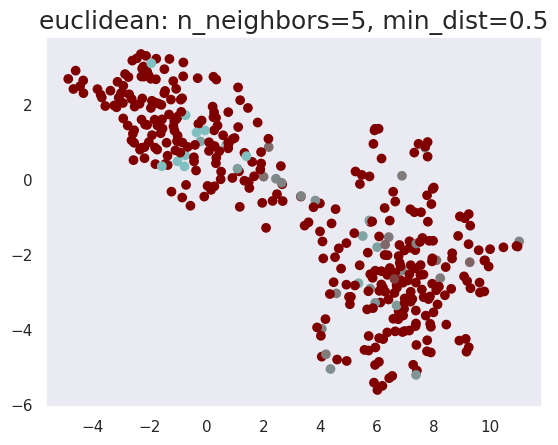

In [19]:
emb_color, zcs = get_embedding_color_v2(result_e3['codebook'])
k = 5
min_dist = 0.5
umap_metric = 'euclidean'
visualize_embedding_umap(result_e3['codebook'], colors=emb_color, edgecolors=None,
          n_neighbors=k, min_dist=min_dist, metric=umap_metric, 
          title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}')

torch.return_types.topk(
values=tensor([0.7556, 0.7540, 0.7535, 0.7533, 0.7520, 0.7519, 0.7517, 0.7512, 0.7403,
        0.7382, 0.6757, 0.6468, 0.6455, 0.6333, 0.6114, 0.6111, 0.6053, 0.5869,
        0.5857, 0.5762, 0.5707, 0.5624, 0.5588, 0.5377, 0.5317, 0.5215, 0.5164,
        0.5112, 0.5104, 0.5091, 0.4878, 0.4858, 0.4837, 0.4797, 0.4703, 0.4379,
        0.4254, 0.4180, 0.4063, 0.3888]),
indices=tensor([325, 345, 106, 253, 234, 308, 109, 125, 285,  55,  27, 188,  71,  18,
         50, 344, 194, 374, 334, 290, 175, 180, 209, 363,   4, 226, 259, 373,
         16, 119, 382, 243,  52,   8, 103, 128,   9,  32, 279,  66]))


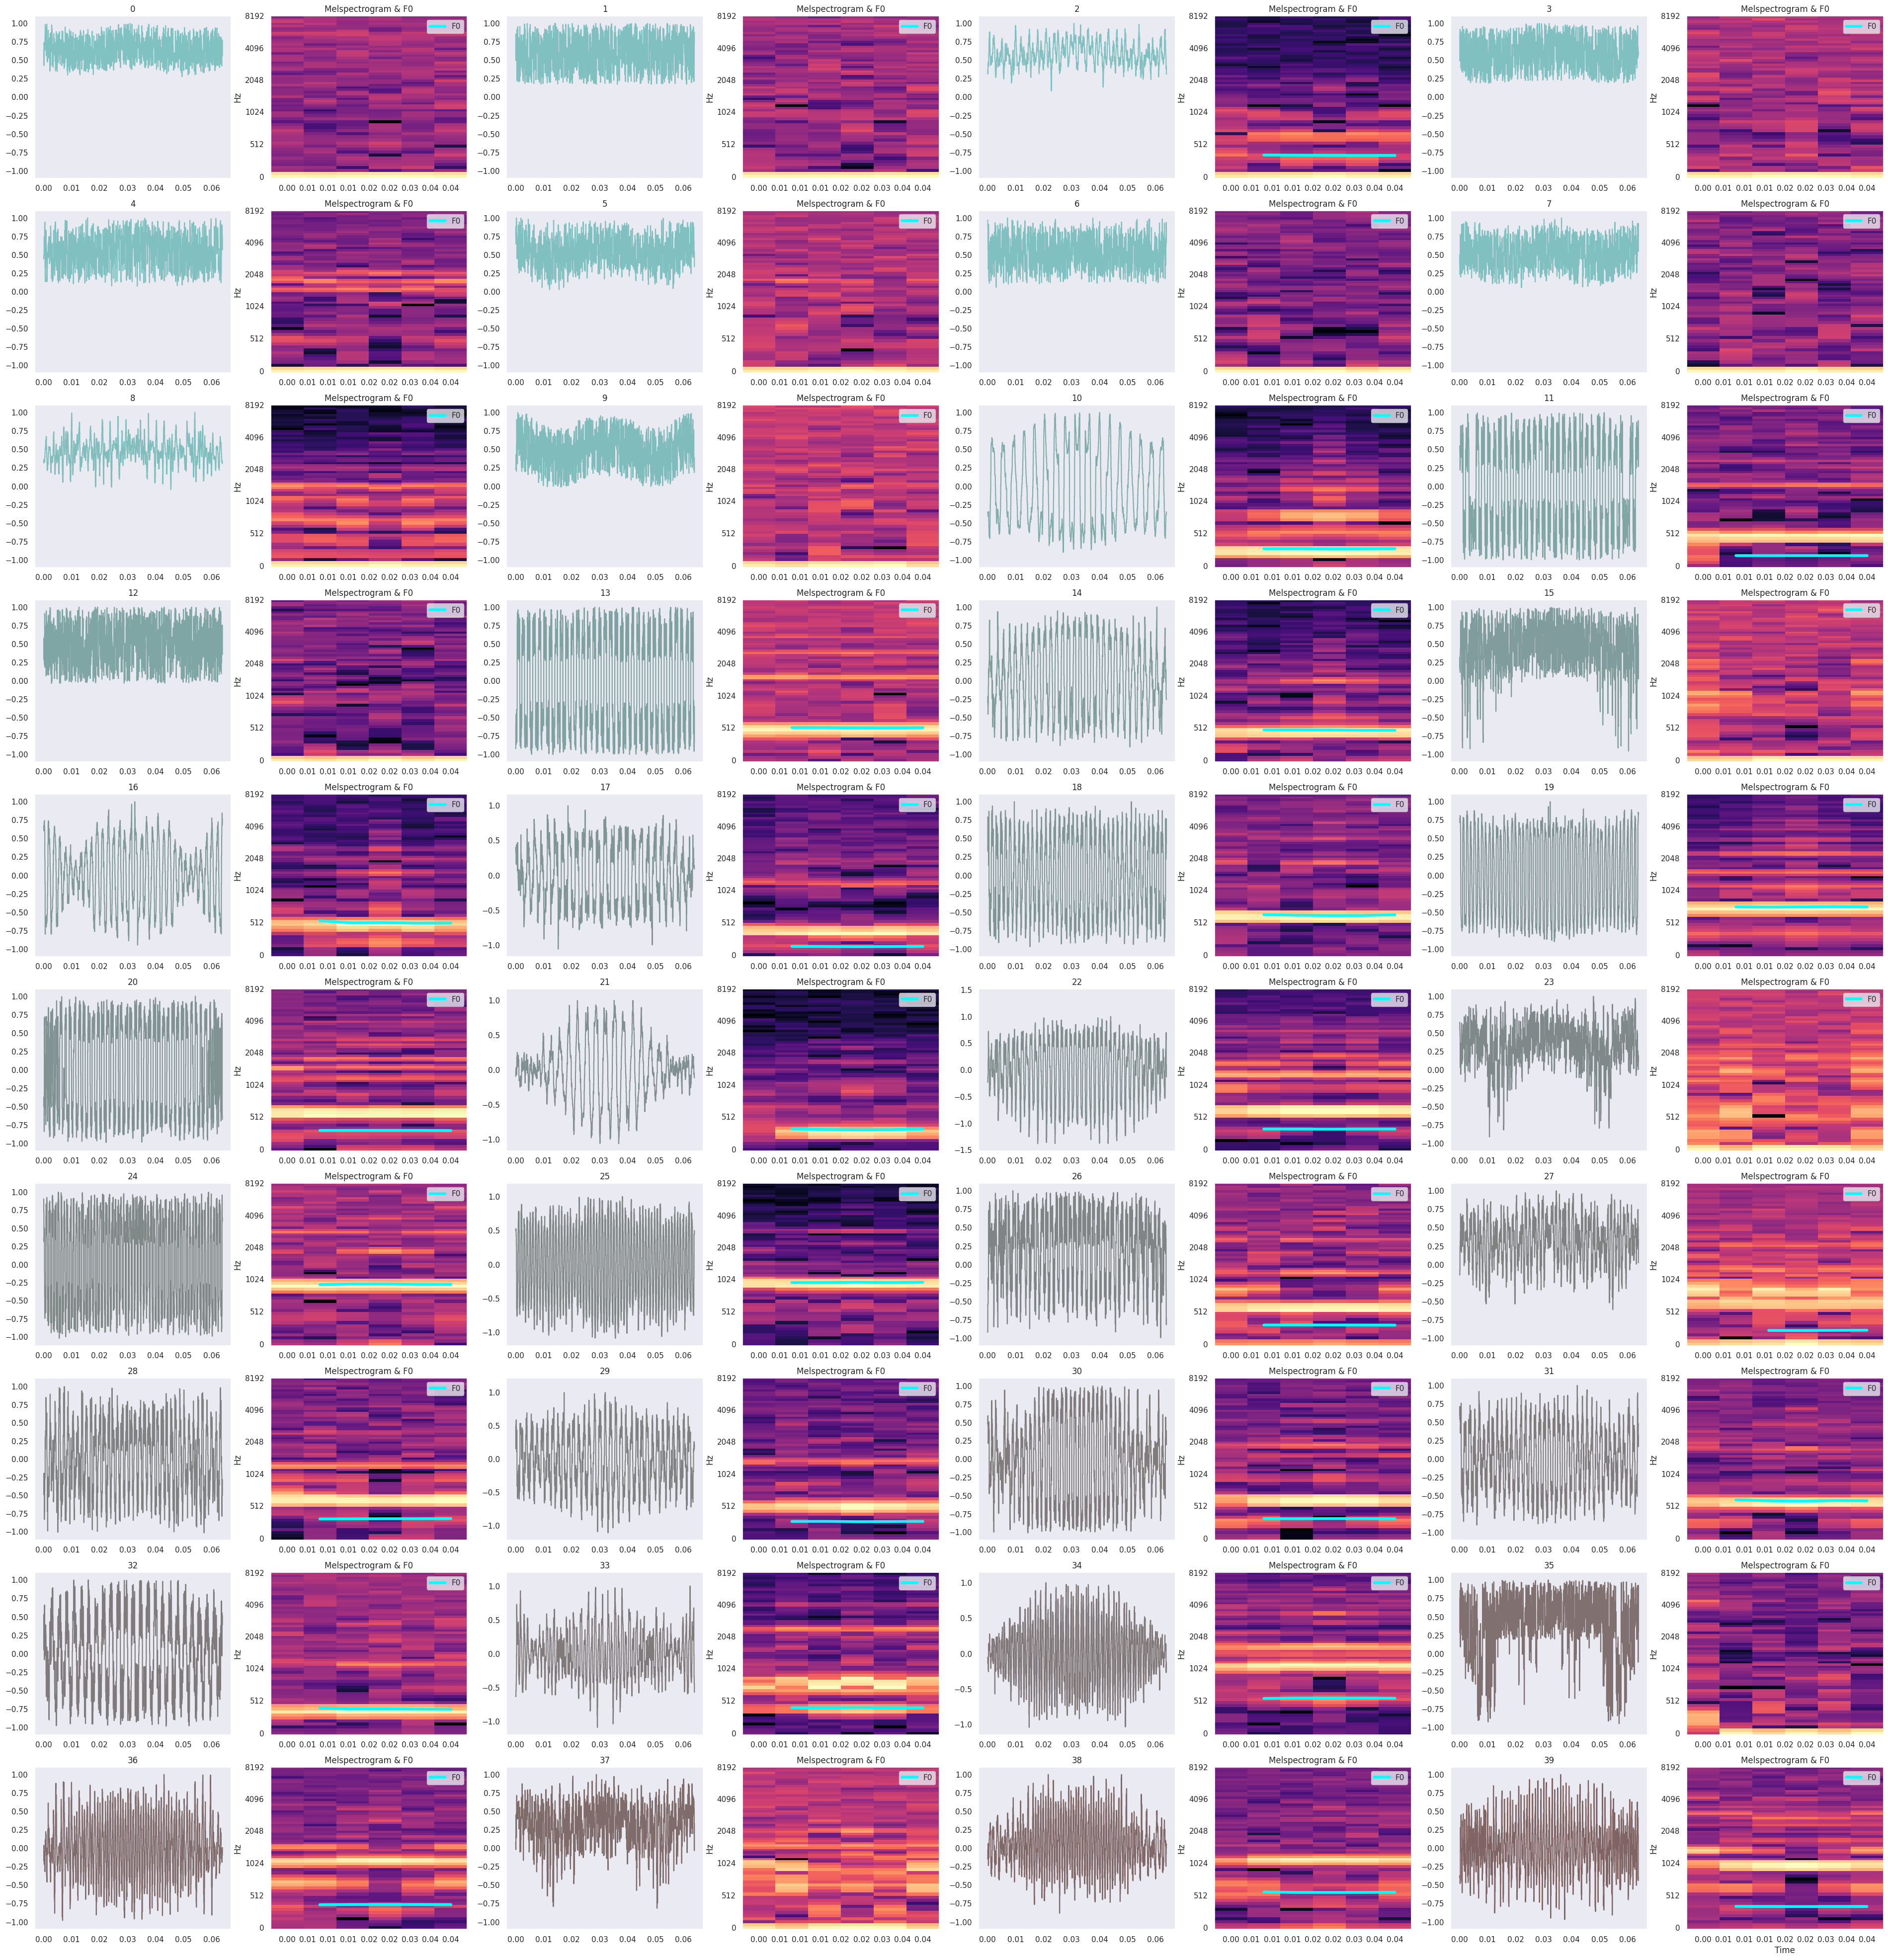

In [20]:
selected_emb_topk = torch.topk(zcs, 40)
print(selected_emb_topk)
selected_idx = selected_emb_topk.indices.tolist()
visualize_speech_codebook(
    codebook_e3[selected_idx], 
    n=80, colors=emb_color[selected_idx])

In [24]:
selected_emb_topk = torch.topk(zcs, 40)
print(selected_emb_topk.indices.tolist())

[325, 345, 106, 253, 234, 308, 109, 125, 285, 55, 27, 188, 71, 18, 50, 344, 194, 374, 334, 290, 175, 180, 209, 363, 4, 226, 259, 373, 16, 119, 382, 243, 52, 8, 103, 128, 9, 32, 279, 66]


In [25]:
selected_emb_topk_idx = selected_emb_topk.indices.tolist()

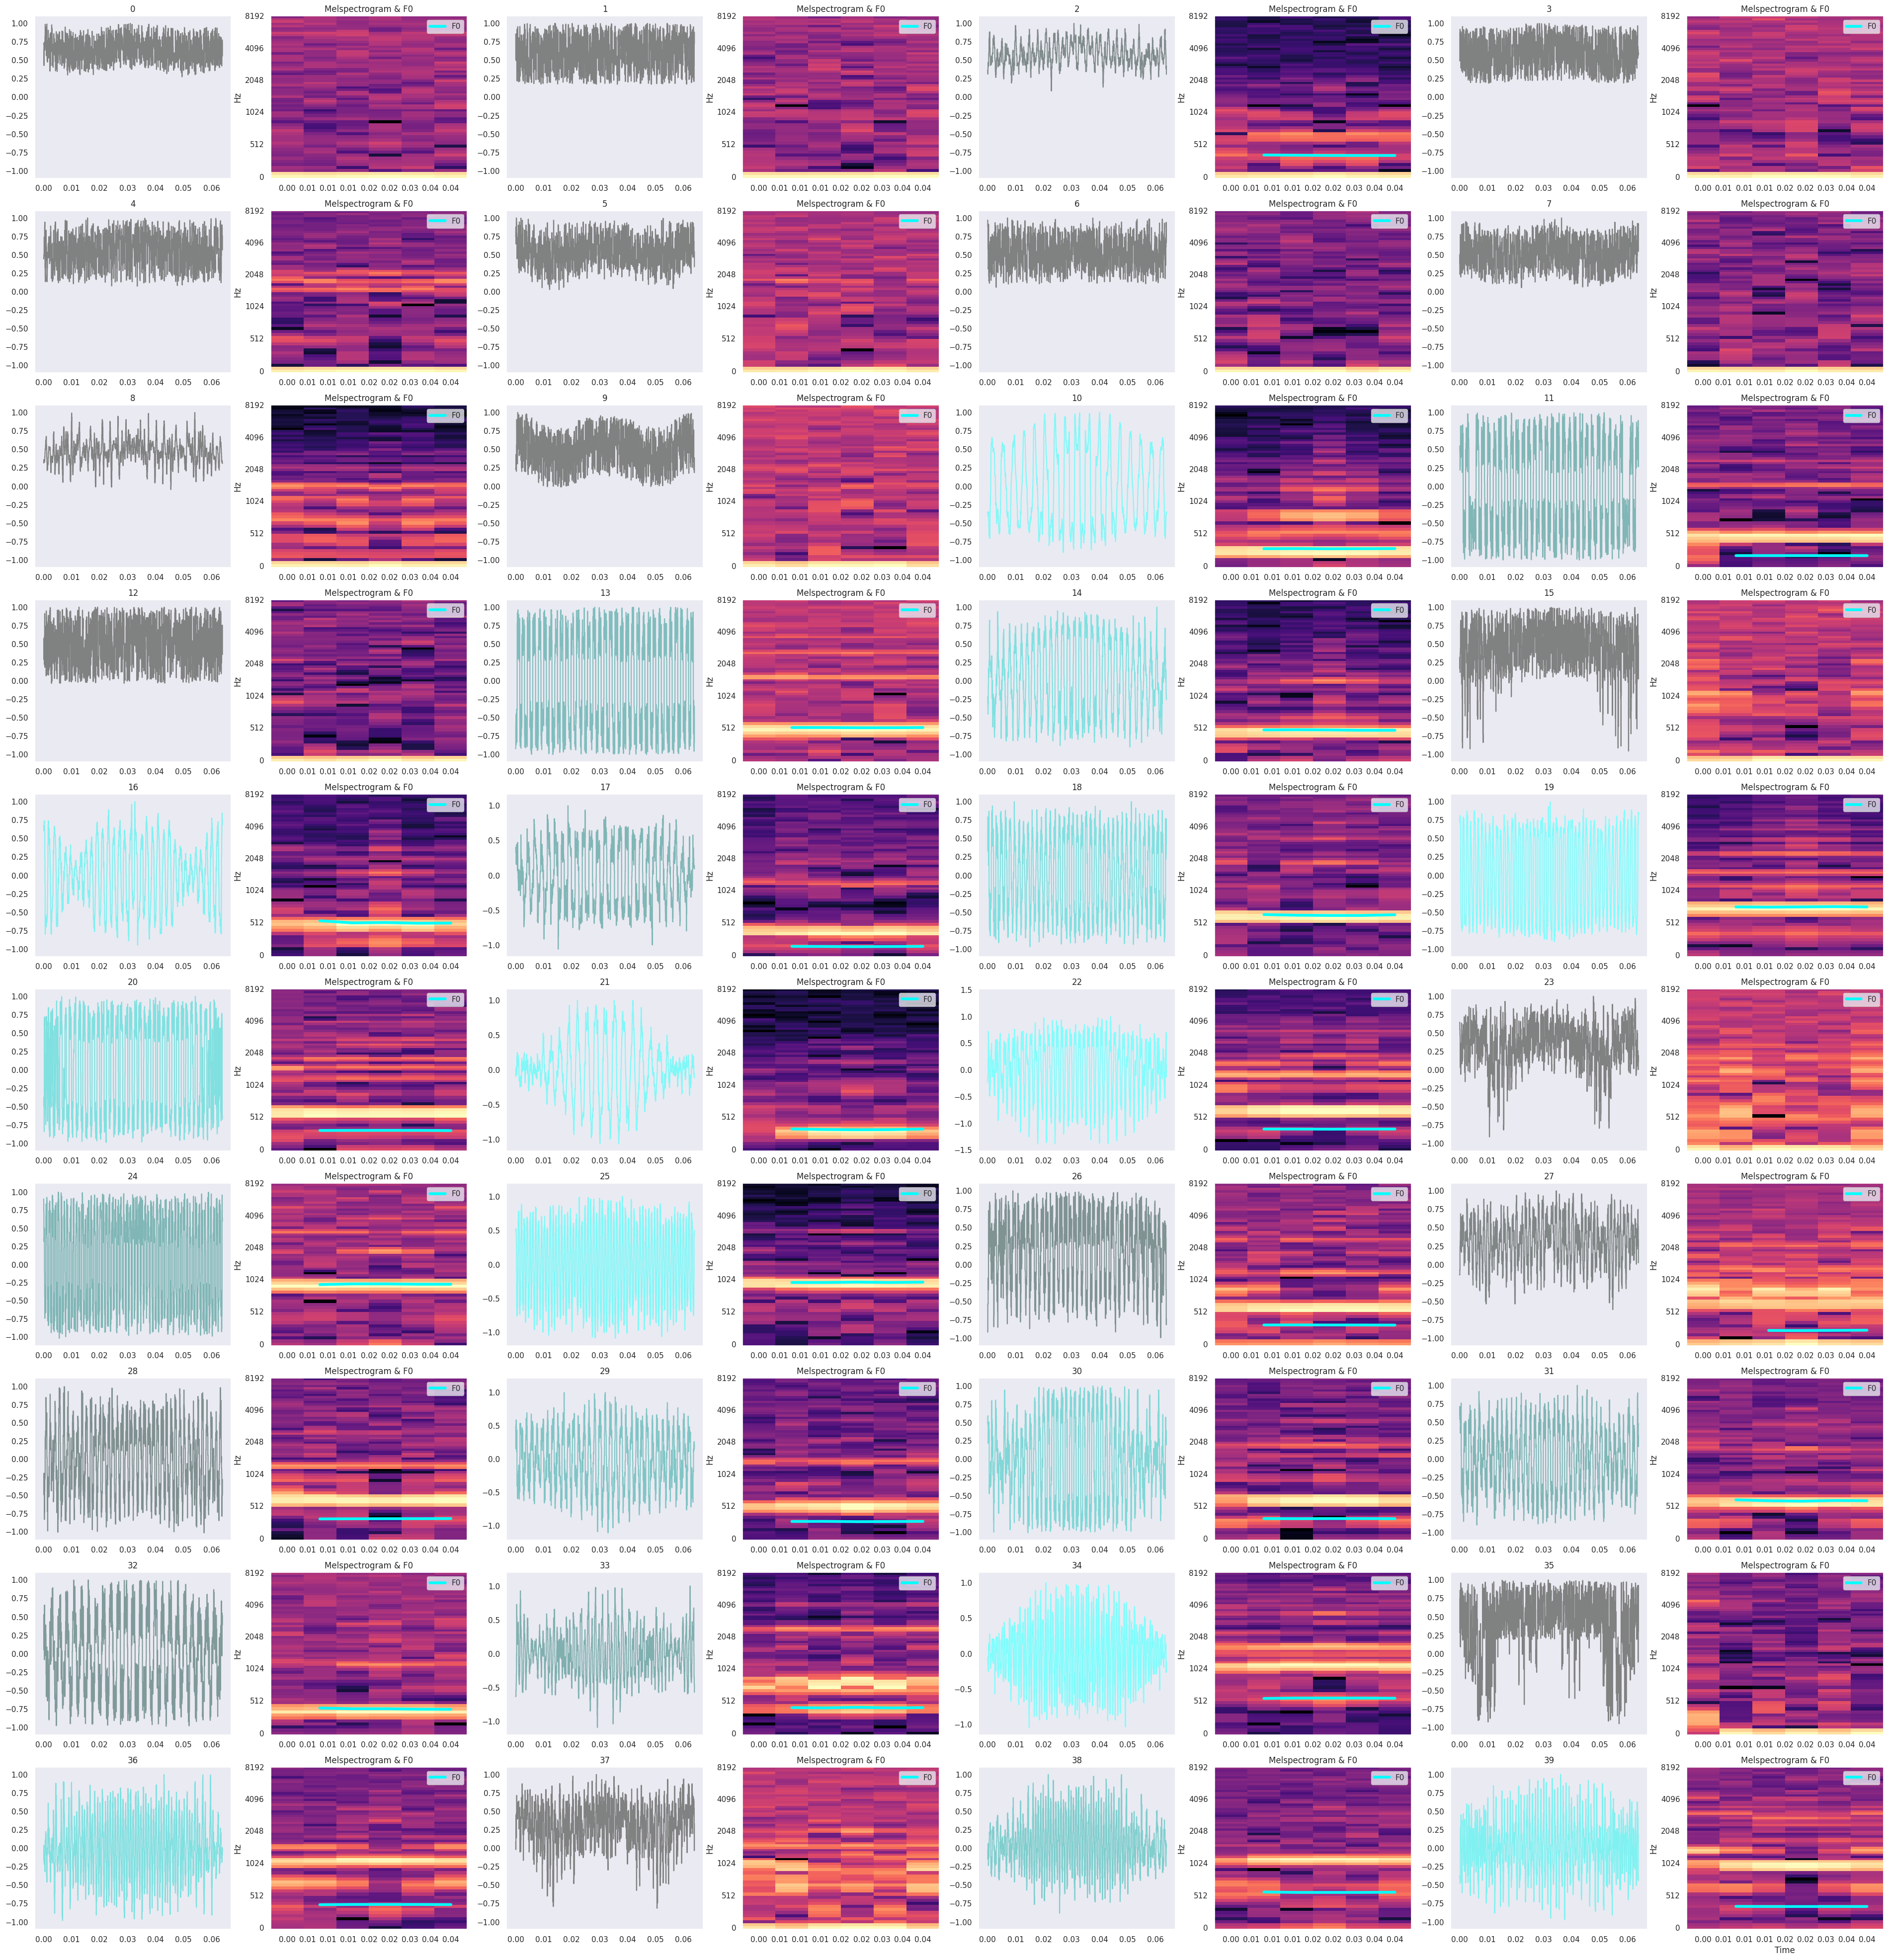

In [47]:
visualize_speech_codebook(
    codebook_e3[selected_emb_topk_idx], 
    n=80, colors=None, default_color=None)

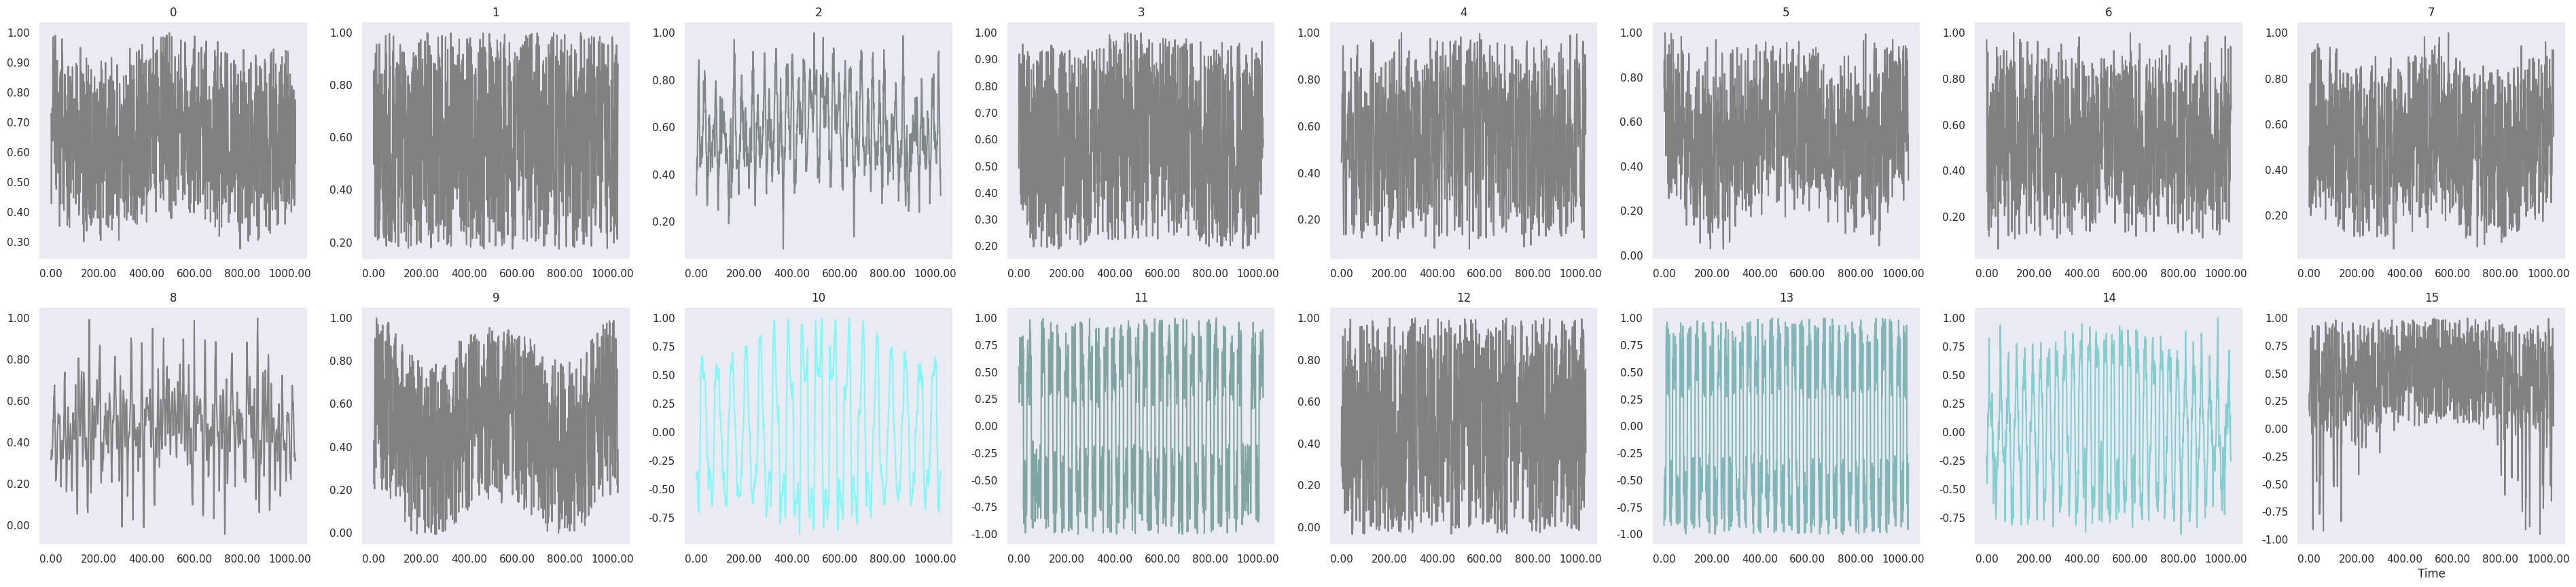

In [61]:
visualize_speech_codebook(
    codebook_e3[selected_emb_topk_idx], 
    n=16, colors=None, default_color=None, 
    feature_mel=False,
    waveplot_librosa=False, y_formatter='{x:02.2f}')

In [49]:
# label: noise=0, voiced=1
selected_filters_idx_with_label = [
    [2, 0], [10, 1], [11, 1], [13, 1], [16, 1],
    [17, 1], [14, 0], [15, 0], [20, 1], [21, 1],
    [18, 1], [19, 1], [24, 1], [25, 1], [22, 1],
    [23, 0], [28, 0], [29, 0], [26, 0], [27, 0],
    [32, 0], [33, 1], [30, 1], [31, 1], [36, 1],
    [37, 0], [34, 1], [35, 0], [38, 1], [39, 1]
]

In [50]:
selected_filters_dict = {}
for i, l in selected_filters_idx_with_label:
    selected_filters_dict[selected_emb_topk_idx[i]] = "voice" if l==1 else "noise"
selected_filters_dict

{106: 'noise',
 27: 'voice',
 188: 'voice',
 18: 'voice',
 194: 'voice',
 374: 'voice',
 50: 'noise',
 344: 'noise',
 175: 'voice',
 180: 'voice',
 334: 'voice',
 290: 'voice',
 4: 'voice',
 226: 'voice',
 209: 'voice',
 363: 'noise',
 16: 'noise',
 119: 'noise',
 259: 'noise',
 373: 'noise',
 52: 'noise',
 8: 'voice',
 382: 'voice',
 243: 'voice',
 9: 'voice',
 32: 'noise',
 103: 'voice',
 128: 'noise',
 279: 'voice',
 66: 'voice'}

In [34]:
import matplotlib as mpl

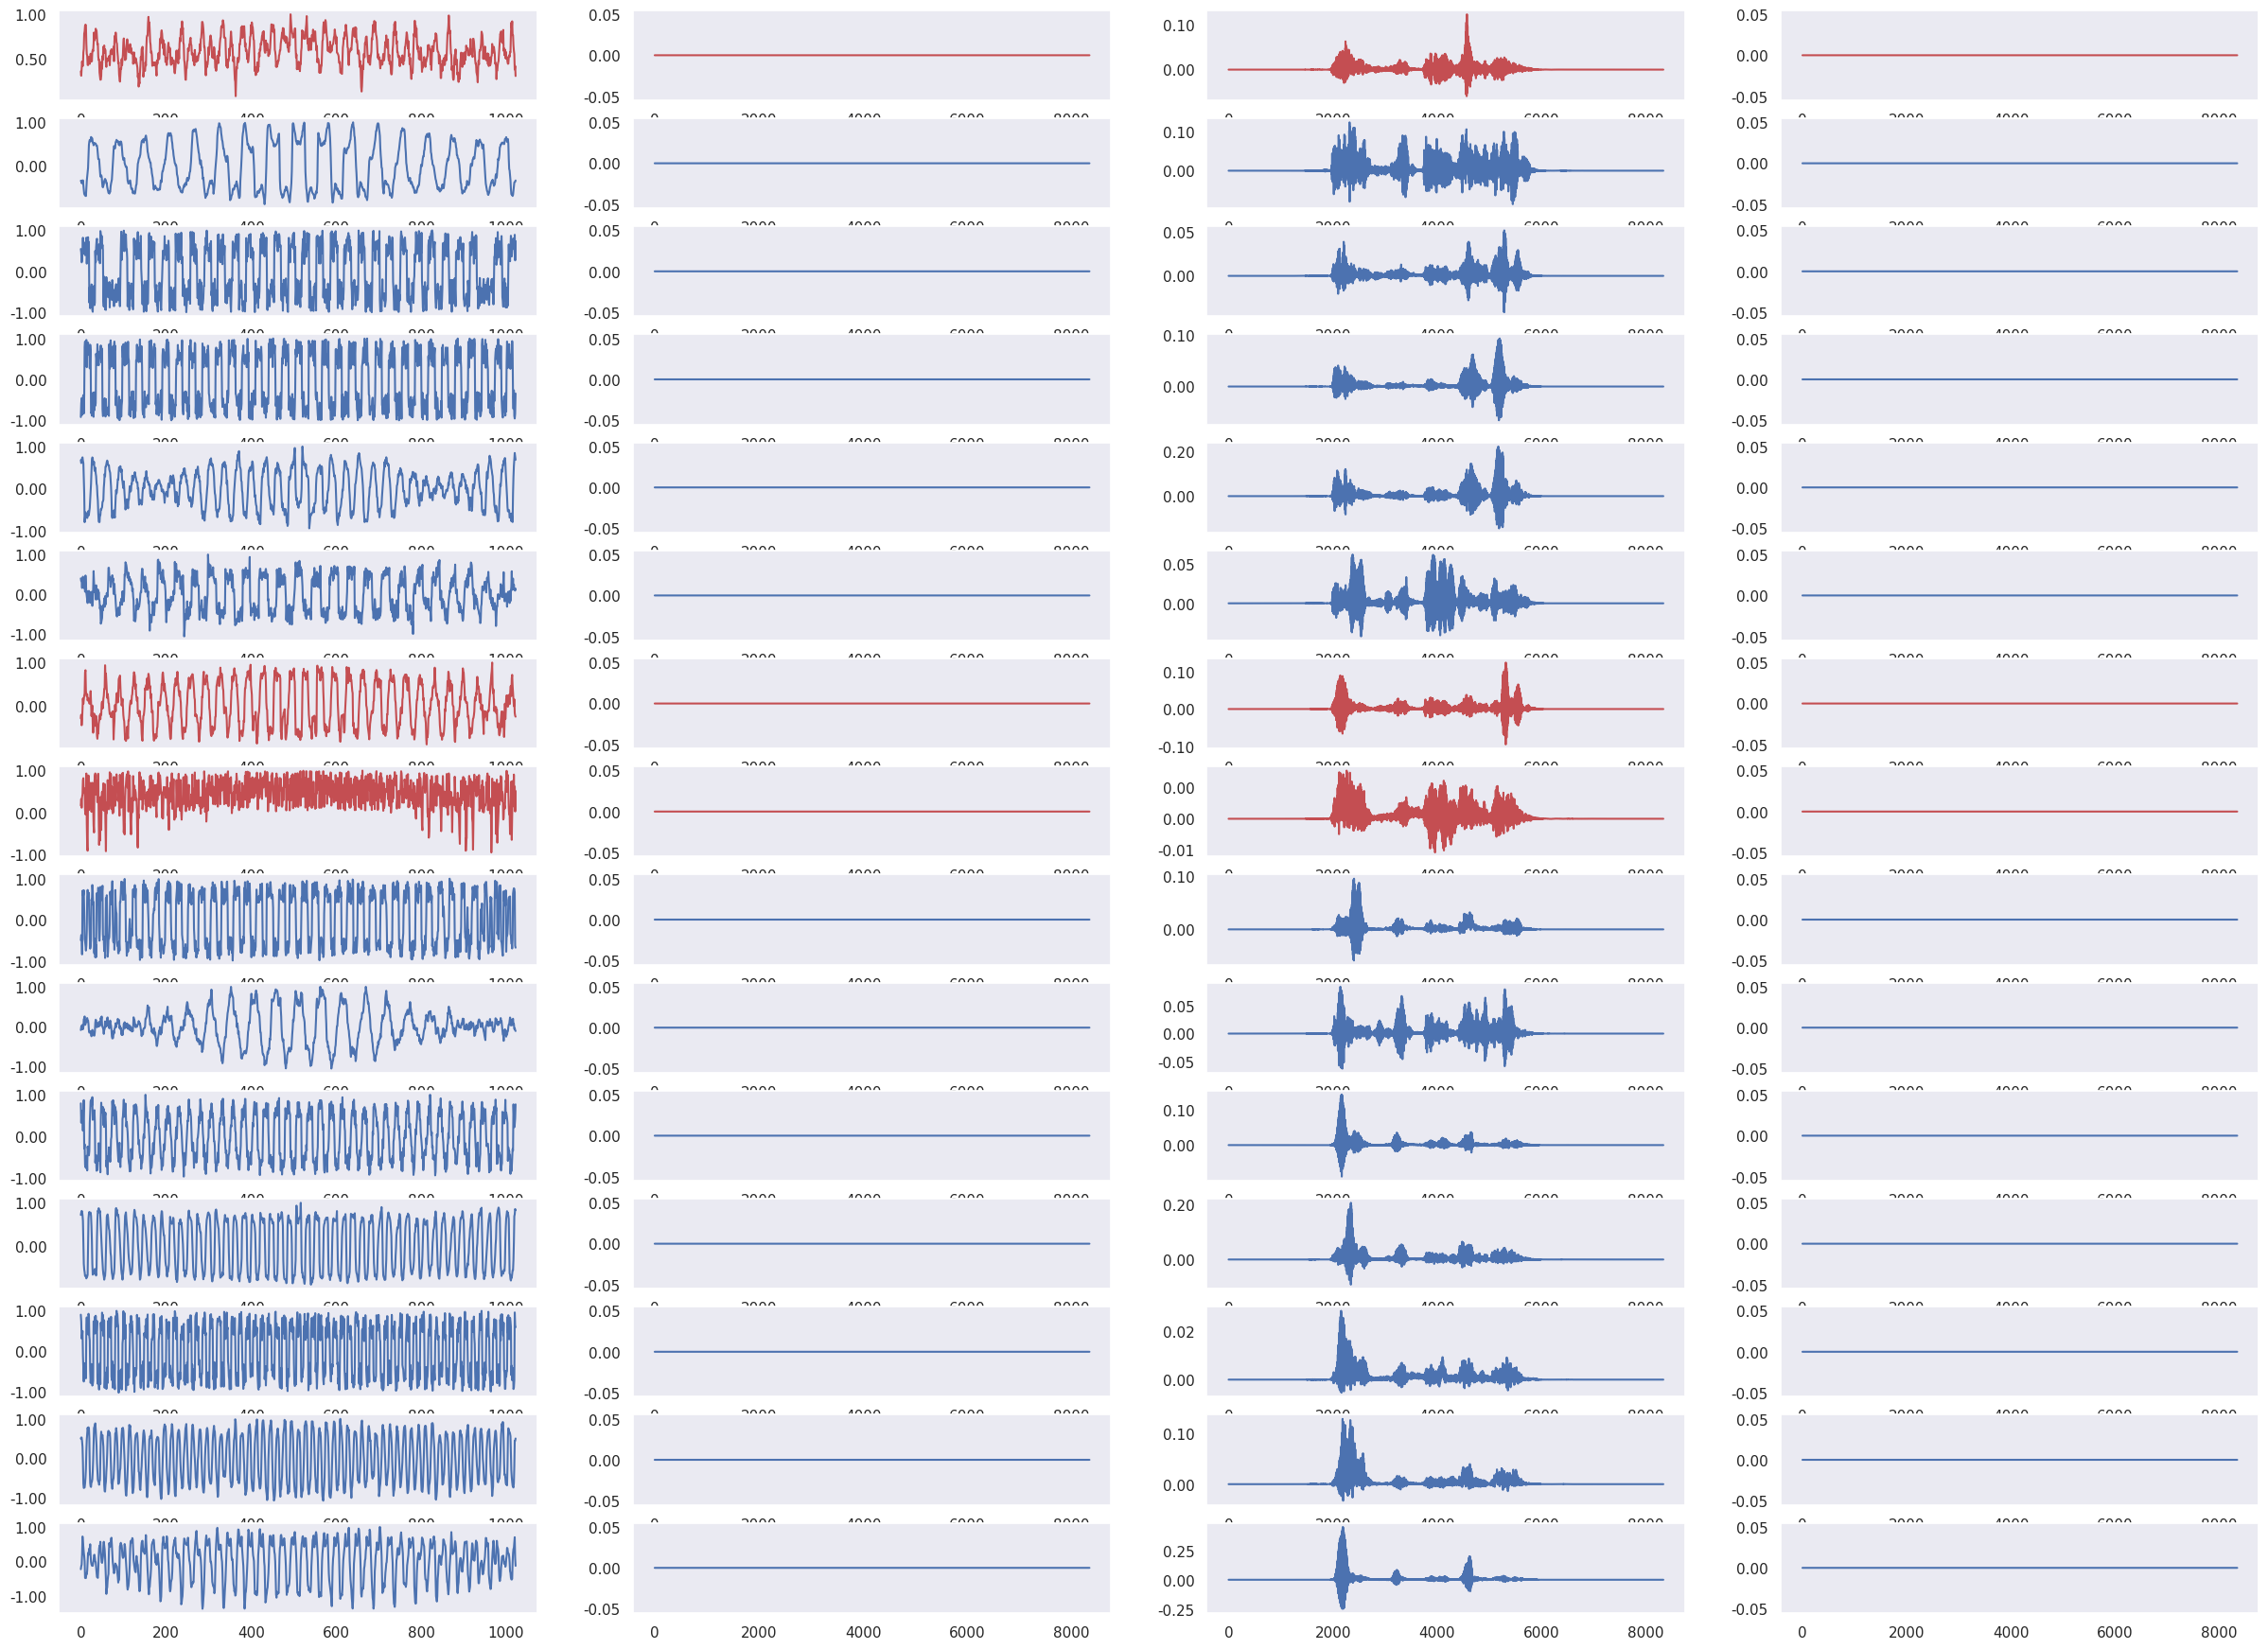

In [51]:
# voice: 20, noise: 10
selected_filters_idx = list(selected_filters_dict.keys())

samples = [0, 1, 2]
fig, axes = plt.subplots(15, 4, figsize=(30,22))
# axes = axes.ravel()
for i, ax in enumerate(axes):
    idx = selected_filters_idx[i]
    color = 'b' if selected_filters_dict[idx]=='voice' else 'r'

    j = 0
    x = codebook_e3[idx, :]
    ax[j].plot(x, color=color)
    ax[j].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:02.2f}'))

    j += 1
    x = result_e3['latents'][samples[j-1], :, idx]
    ax[j].plot(x, color=color)
    ax[j].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:02.2f}'))

    j += 1
    x = result_e3['latents'][samples[j-1], :, idx]
    ax[j].plot(x, color=color)
    ax[j].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:02.2f}'))

    j += 1
    x = result_e3['latents'][samples[j-1], :, idx]
    ax[j].plot(x, color=color)
    ax[j].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:02.2f}'))

In [36]:
log_img_dir = f'../{experiment_prefix}_models/latent_img/'

In [37]:
fig.savefig(f'{log_img_dir}epoch3_0.png', bbox_inches='tight')

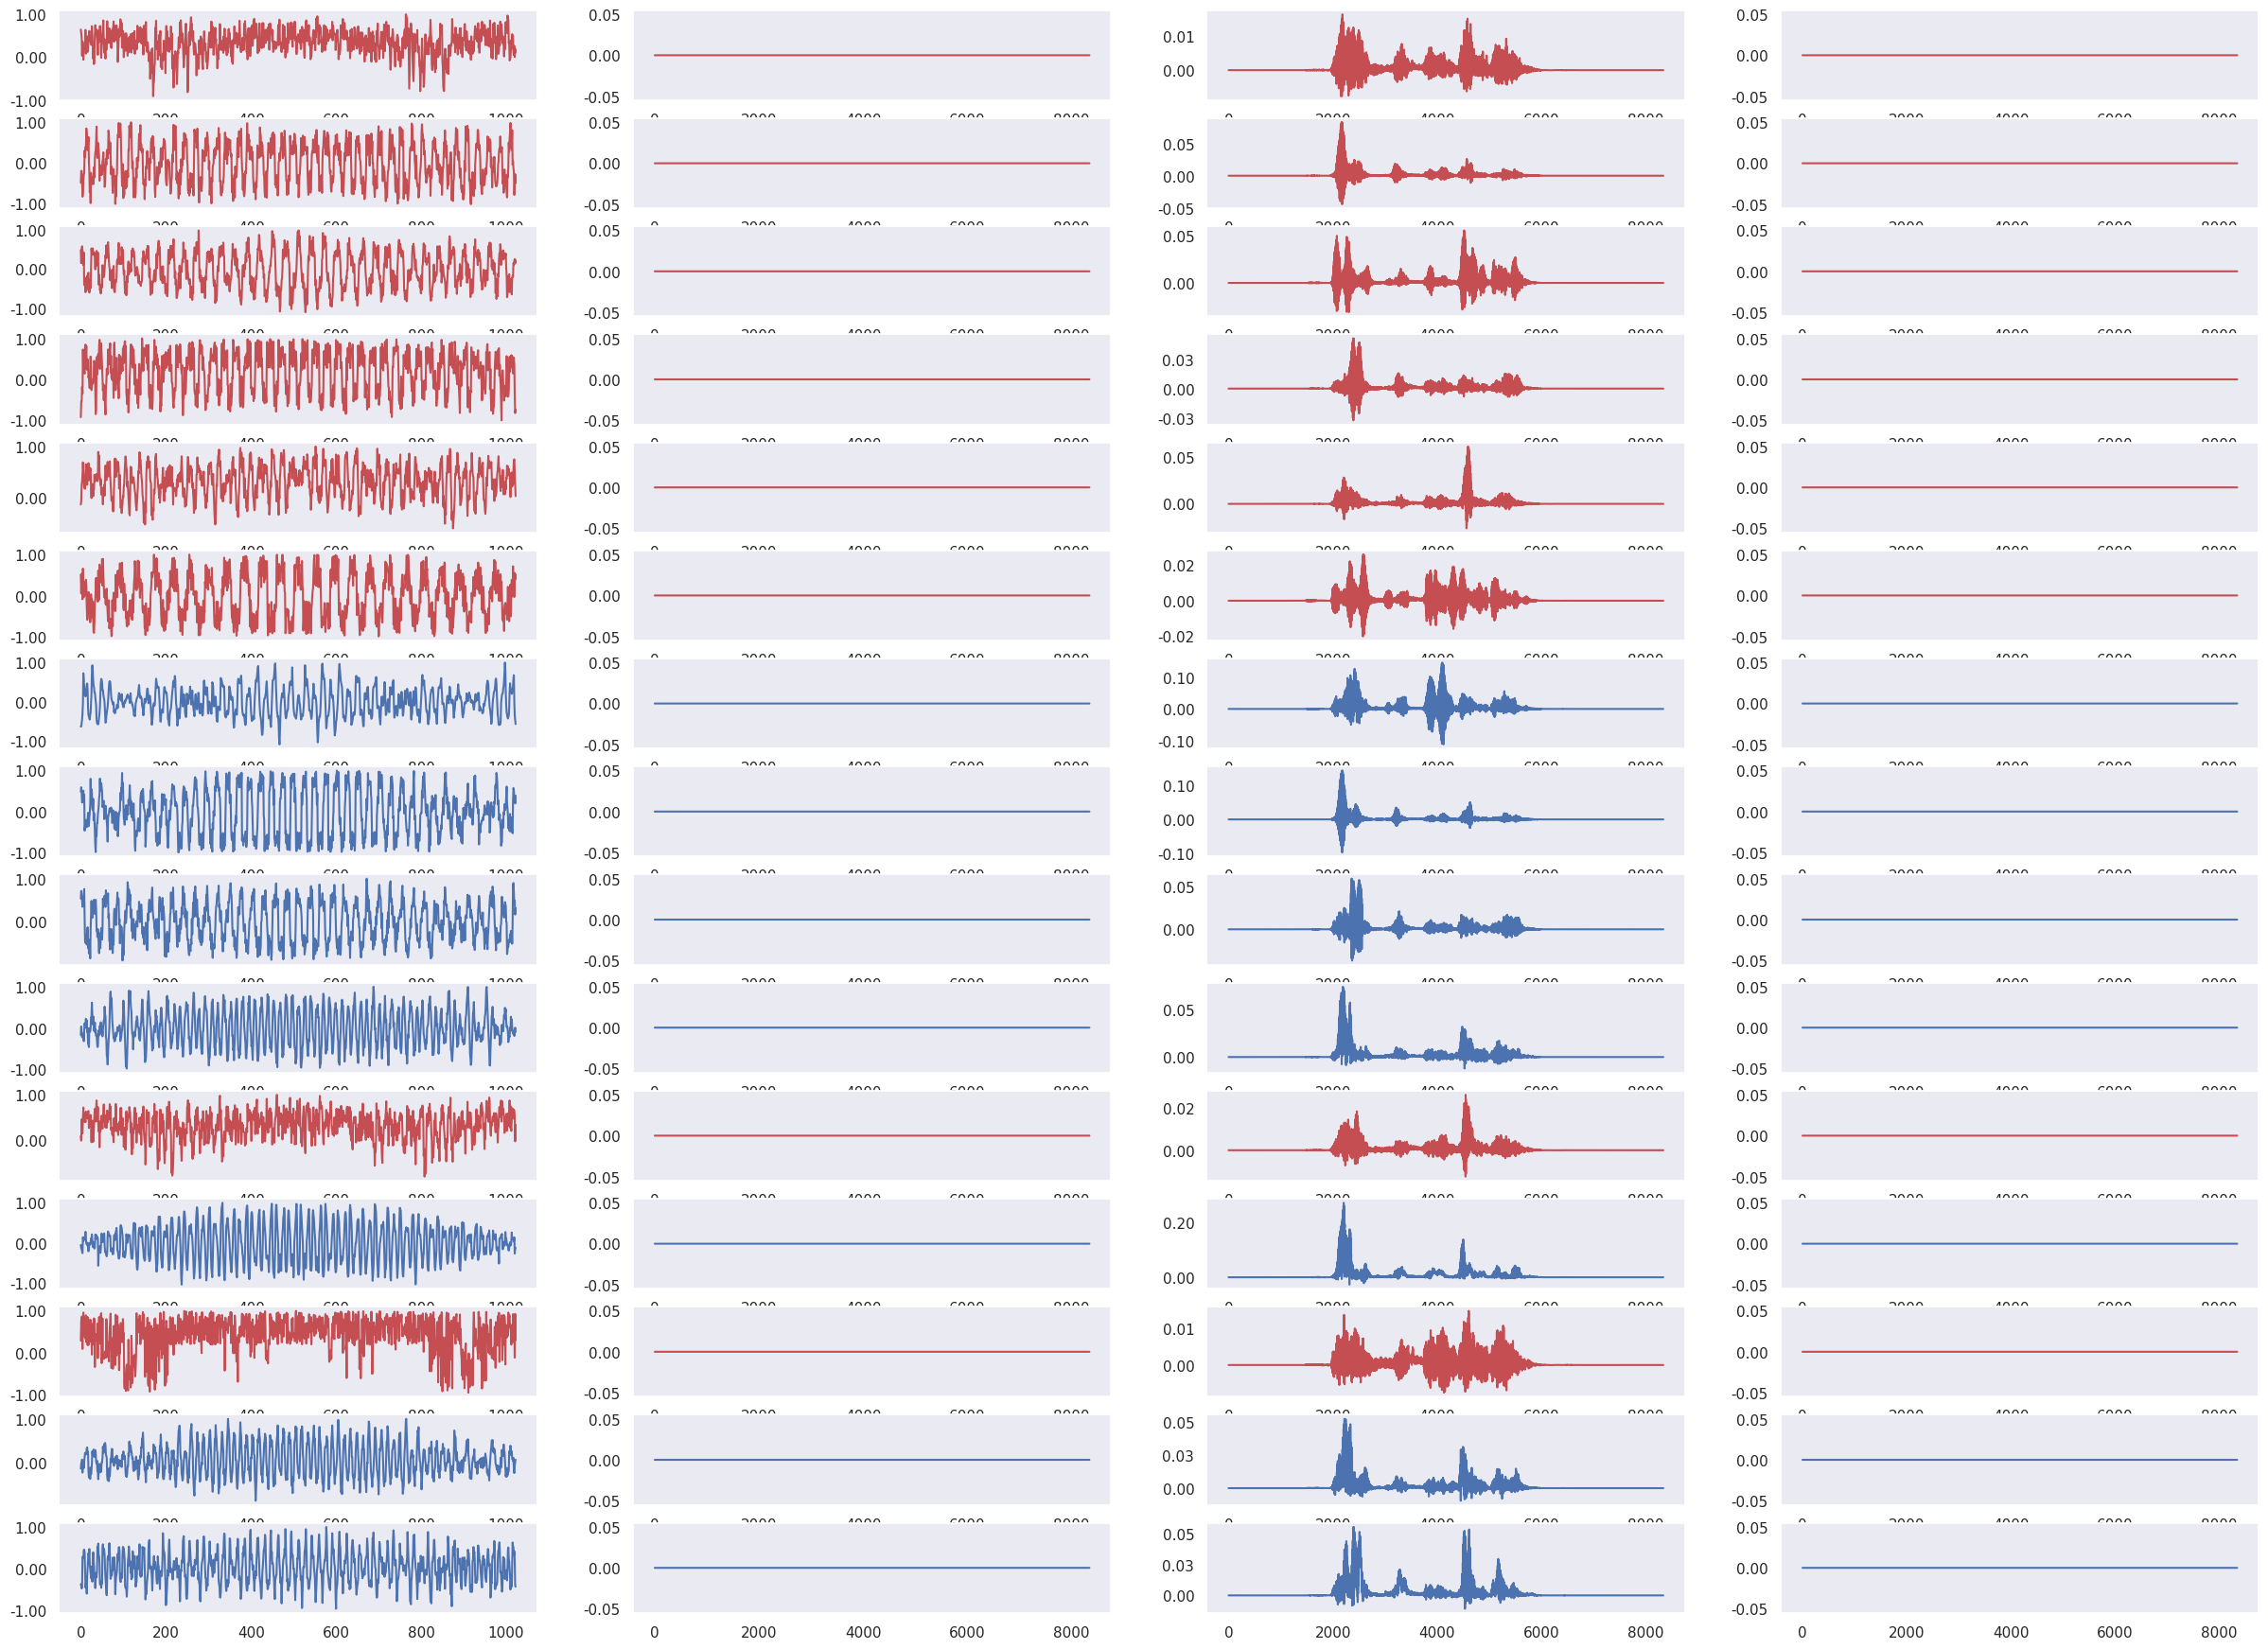

In [52]:
samples = [0, 1, 2]
fig, axes = plt.subplots(15, 4, figsize=(30,22))
# axes = axes.ravel()
for i, ax in enumerate(axes):
    idx = selected_filters_idx[15+i]
    color = 'b' if selected_filters_dict[idx]=='voice' else 'r'

    j = 0
    x = codebook_e3[idx, :]
    ax[j].plot(x, color=color)
    ax[j].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:02.2f}'))

    j += 1
    x = result_e3['latents'][samples[j-1], :, idx]
    ax[j].plot(x, color=color)
    ax[j].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:02.2f}'))

    j += 1
    x = result_e3['latents'][samples[j-1], :, idx]
    ax[j].plot(x, color=color)
    ax[j].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:02.2f}'))

    j += 1
    x = result_e3['latents'][samples[j-1], :, idx]
    ax[j].plot(x, color=color)
    ax[j].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:02.2f}'))

fig.savefig(f'{log_img_dir}epoch3_1.png', bbox_inches='tight')

In [53]:
def save_latent_plots(filename, epoch, frequency=3, dpi=100, idx_offset=0, img_suffix=0):
    if epoch % frequency == 0:
        data_dict = torch.load(filename)
        latents = data_dict['latents'].numpy()
        codebook = data_dict['codebook'].numpy()
        samples = [0, 1, 2]
        fig, axes = plt.subplots(15, 4, figsize=(30,22))
        for i, ax in enumerate(axes):
            idx = selected_filters_idx[idx_offset+i]
            color = 'b' if selected_filters_dict[idx]=='voice' else 'r'
        
            j = 0
            x = codebook[idx, :]
            ax[j].plot(x, color=color)
            ax[j].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:02.2f}'))
        
            j += 1
            x = latents[samples[j-1], :, idx]
            ax[j].plot(x, color=color)
            ax[j].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:02.2f}'))
        
            j += 1
            x = latents[samples[j-1], :, idx]
            ax[j].plot(x, color=color)
            ax[j].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:02.2f}'))
        
            j += 1
            x = latents[samples[j-1], :, idx]
            ax[j].plot(x, color=color)
            ax[j].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:02.2f}'))
            
        fig.savefig(f'{log_img_dir}epoch{epoch}_{img_suffix}.png', bbox_inches='tight', dpi=dpi)
        plt.close(fig)

In [54]:
df.apply(
    lambda x: save_latent_plots(
        x['filename'], x['epoch'], dpi=100,
         idx_offset=0, img_suffix=0), axis=1)

0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
18    None
19    None
20    None
21    None
22    None
23    None
24    None
25    None
26    None
27    None
28    None
29    None
30    None
31    None
32    None
33    None
34    None
35    None
36    None
37    None
38    None
39    None
40    None
41    None
42    None
43    None
44    None
45    None
46    None
47    None
48    None
49    None
50    None
dtype: object

In [42]:
from PIL  import Image

In [43]:
log_gif_dir = f'../{experiment_prefix}_models/gifs/'

In [44]:
def make_gif(img_list, out_filename, out_dir=log_gif_dir, duration=100, resize=None):
    if resize is None:
        frames = [Image.open(image) for image in img_list]
    else:
        frames = [Image.open(image).resize(resize) for image in img_list]
    frame_one = frames[0]
    frame_one.save(f'{out_dir}{out_filename}.gif', 
                   format="GIF", append_images=frames, save_all=True, duration=duration, loop=0)

In [55]:
img_list = glob.glob(f'{log_img_dir}*0.png')
make_gif(img_list, 'latents_0', resize=None) #(2397,1743))

In [59]:
img_list = glob.glob(f'{log_img_dir}*_1.png')
make_gif(img_list, 'latents_1', resize=(2397,1743)) 

In [ ]:
log_img_dir = f'../scb8_models/img/'

In [ ]:
visualize_speech_codebook(
    codebook_e3[selected_emb_topk_idx], 
    n=16, colors=None, default_color=None, 
    feature_mel=False,
    waveplot_librosa=False, y_formatter='{x:02.2f}')

In [62]:
def plot_and_save(
    codebook, ncols, nrows, filename, 
    img_dir=log_img_dir, dpi=100
):
    (fig, axes) = visualize_speech_codebook(
        waves=codebook, 
        colors=None, default_color=None,
        title="Code ",
        n=ncols*nrows,
        feature_mel=False,
        figsize_unit=(3,3),
        ncols=ncols,
        return_plot=True,
        waveplot_librosa=False, y_formatter='{x:02.2f}')
    
    axes = axes.ravel()
    for a in axes:
        a.axis('off')
    fig.savefig(f'{img_dir}{filename}', bbox_inches='tight', dpi=dpi)
    plt.close(fig)

def save_emb_plots(filename, epoch, frequency=5, dpi=100):
    if epoch % frequency == 0:
        codebook = torch.load(filename)['codebook'].numpy()
        ncols, nrows = 16, 12
        n = ncols*nrows
        plot_and_save(
            codebook[:n], ncols, nrows, 
            filename=f'epoch{epoch}_0.png', dpi=dpi)
        plot_and_save(
            codebook[-n:], ncols, nrows, 
            filename=f'epoch{epoch}_1.png', dpi=dpi)

In [63]:
df.apply(
    lambda x: save_emb_plots(
        x['filename'], x['epoch'], dpi=100), axis=1)

0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
18    None
19    None
20    None
21    None
22    None
23    None
24    None
25    None
26    None
27    None
28    None
29    None
30    None
31    None
32    None
33    None
34    None
35    None
36    None
37    None
38    None
39    None
40    None
41    None
42    None
43    None
44    None
45    None
46    None
47    None
48    None
49    None
50    None
dtype: object

In [ ]:
log_img_dir

In [66]:
glob.glob(f'../scb8_models/img/*0.png')

['../scb8_models/img/epoch25_0.png',
 '../scb8_models/img/epoch45_0.png',
 '../scb8_models/img/epoch30_0.png',
 '../scb8_models/img/epoch40_0.png',
 '../scb8_models/img/epoch35_0.png',
 '../scb8_models/img/epoch20_0.png',
 '../scb8_models/img/epoch5_0.png',
 '../scb8_models/img/epoch10_0.png',
 '../scb8_models/img/epoch50_0.png',
 '../scb8_models/img/epoch15_0.png']

In [67]:
img_list = glob.glob(f'../scb8_models/img/*0.png')
make_gif(img_list, 'codebook_0', resize=None) #(2397,1743))

In [68]:
img_list = glob.glob(f'../scb8_models/img/*1.png')
make_gif(img_list, 'codebook_1', resize=None) #(2397,1743))